In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

In [3]:
df = pd.read_parquet("../data/processed/audio_features.parquet")
df.head(3)

,filename,modality,vocal_channel,emotion,emontion_intensity,statement,repetition,actor,gender
0,../data/raw/emotional-speech-audio/1/Actor_24/...,audio-only,speech,calm,normal,Kids are talking by the door,1st repetition,1,male
1,../data/raw/emotional-speech-audio/1/Actor_24/...,audio-only,speech,surprised,normal,Kids are talking by the door,1st repetition,1,male
2,../data/raw/emotional-speech-audio/1/Actor_24/...,audio-only,speech,happy,normal,Dogs are sitting by the door,1st repetition,1,male


## Checking Imbalance

In [9]:
df.columns

Index(['filename', 'modality', 'vocal_channel', 'emotion',
       'emontion_intensity', 'statement', 'repetition', 'actor', 'gender'],
      dtype='object')

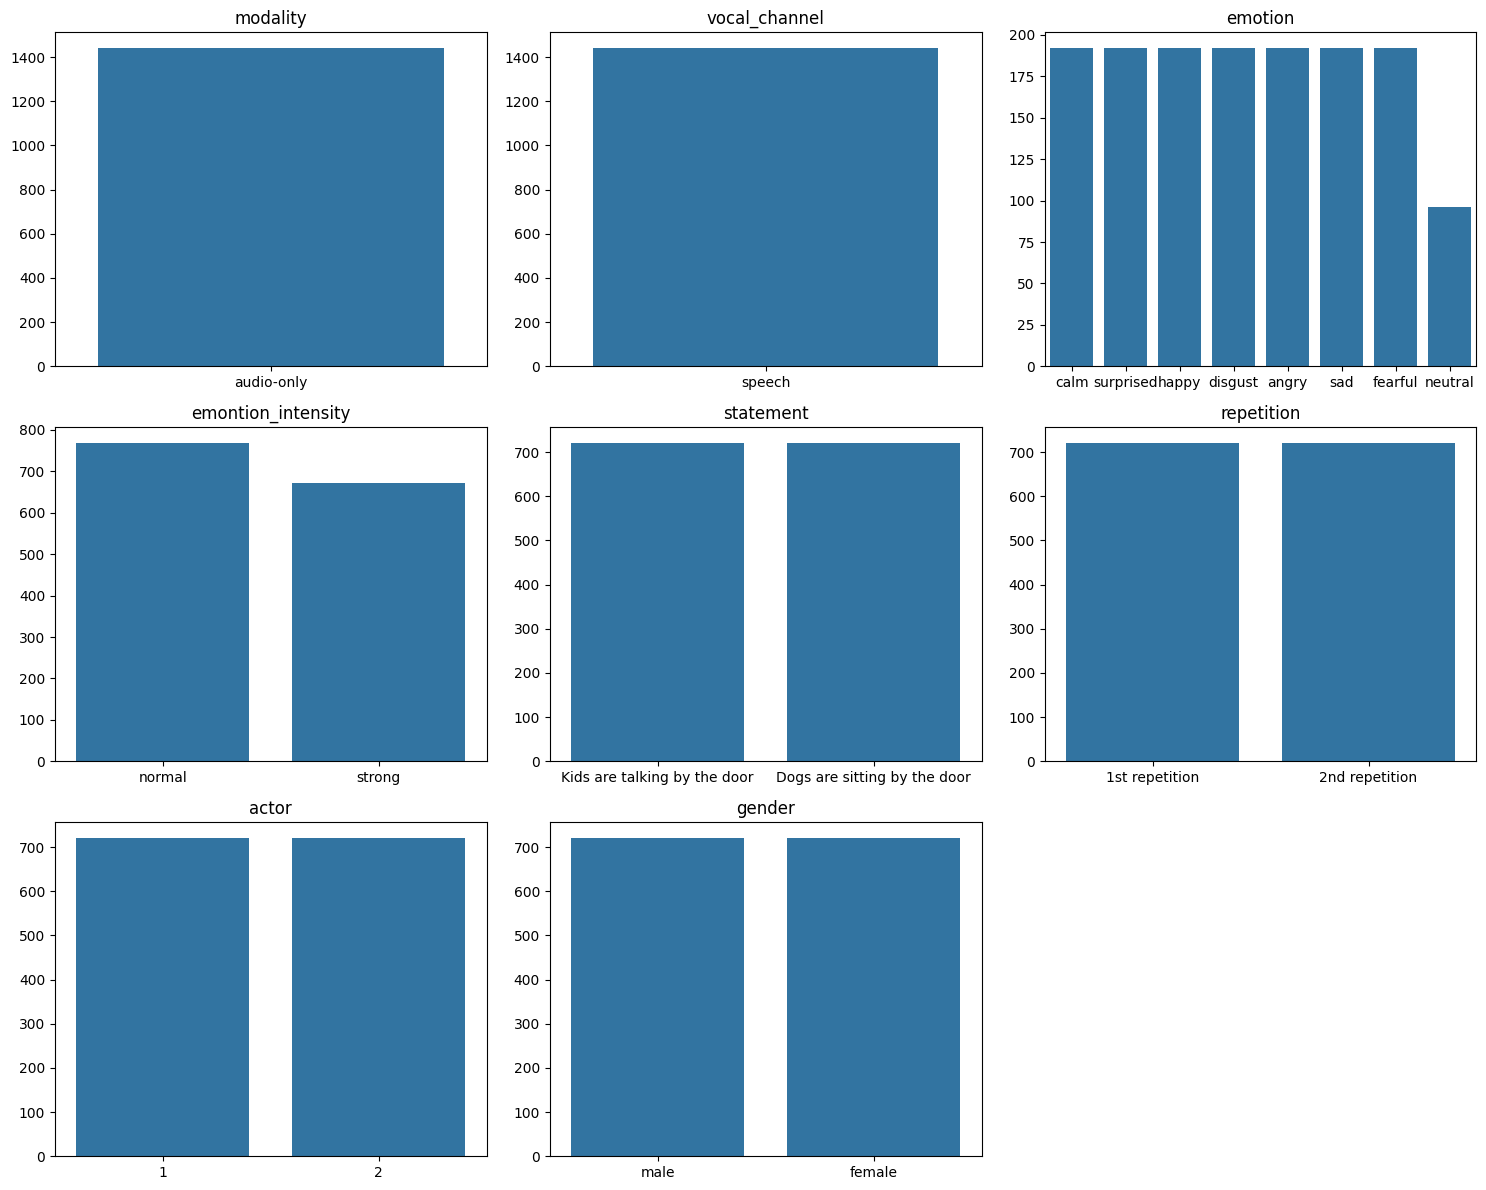

In [12]:
cols = df.drop("filename", axis=1).columns
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(cols):
    ax = axes[i]
    counts = df[col].value_counts()
    sns.barplot(x=counts.index, y=counts.values, ax=ax)
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("")

for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

It seems fine for most of the features, but the "neutral" label in the emotion column is almost the half of the other labels, this might cause the model to underpredict "neutral" so we will take this in consideration when modelling.

In [13]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

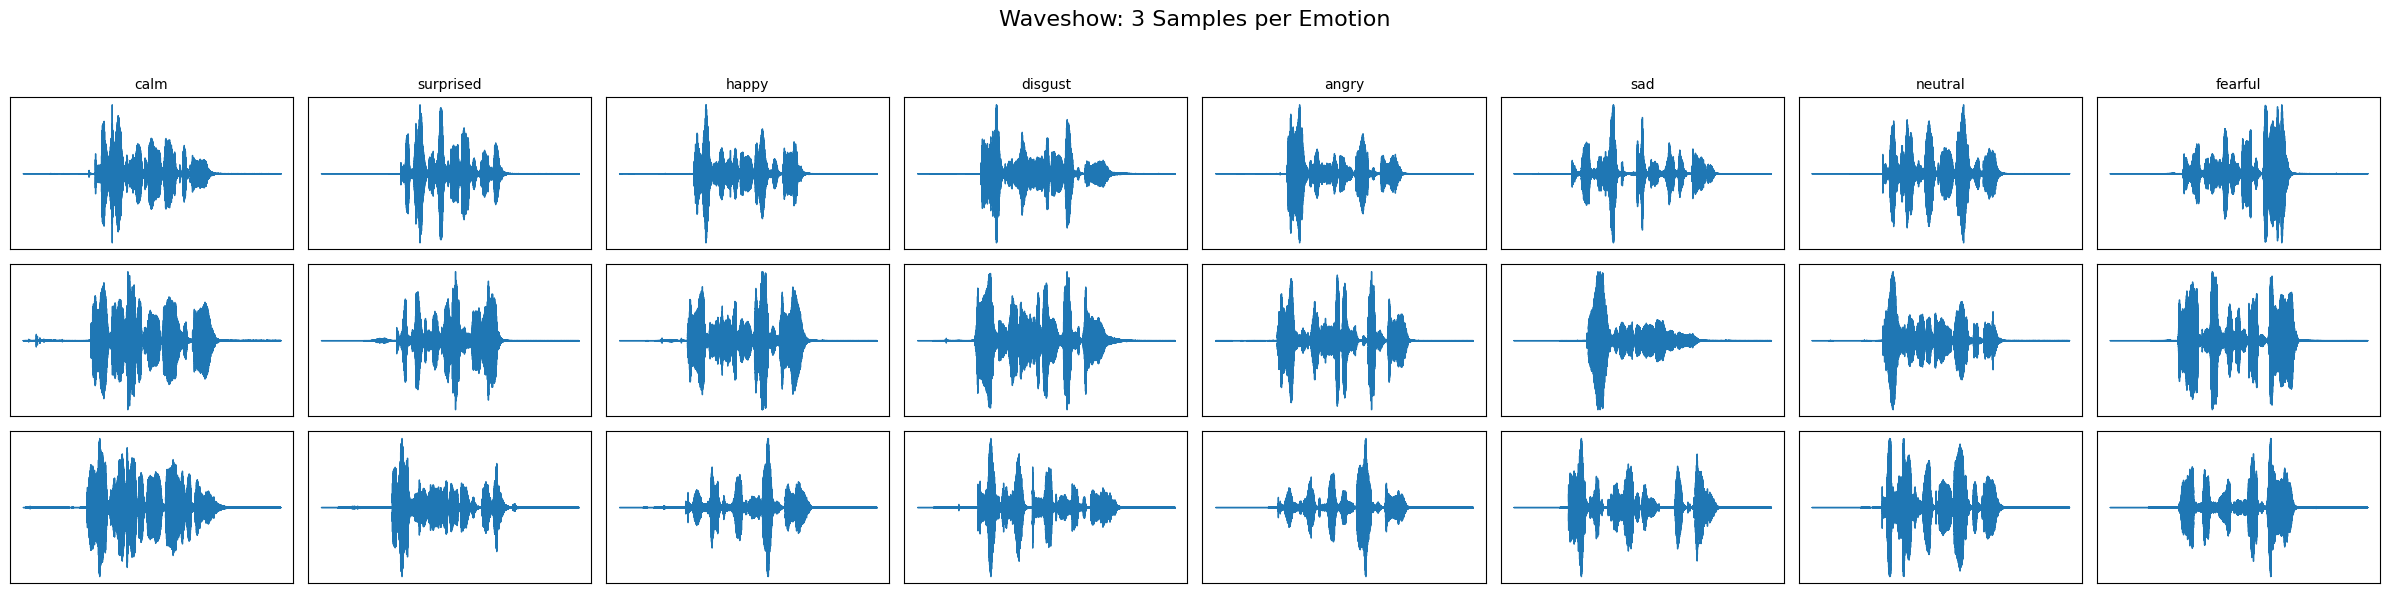

In [25]:
emotion_labels = df['emotion'].unique()

fig, axes = plt.subplots(3, 8, figsize=(24, 6))
fig.suptitle('Waveshow: 3 Samples per Emotion', fontsize=16)

for col_idx, emotion in enumerate(emotion_labels):
    emotion_samples = df[df['emotion'] == emotion].head(3)
    
    for row_idx, (_, row) in enumerate(emotion_samples.iterrows()):
        path = row['filename']
        data, sampling_rate = librosa.load(path)

        ax = axes[row_idx, col_idx]
        librosa.display.waveshow(data, sr=sampling_rate, ax=ax)
        ax.set_xlabel("")
        
        if row_idx == 0:
            ax.set_title(emotion, fontsize=10)
        
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

/tmp/ipykernel_5372/3271913634.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


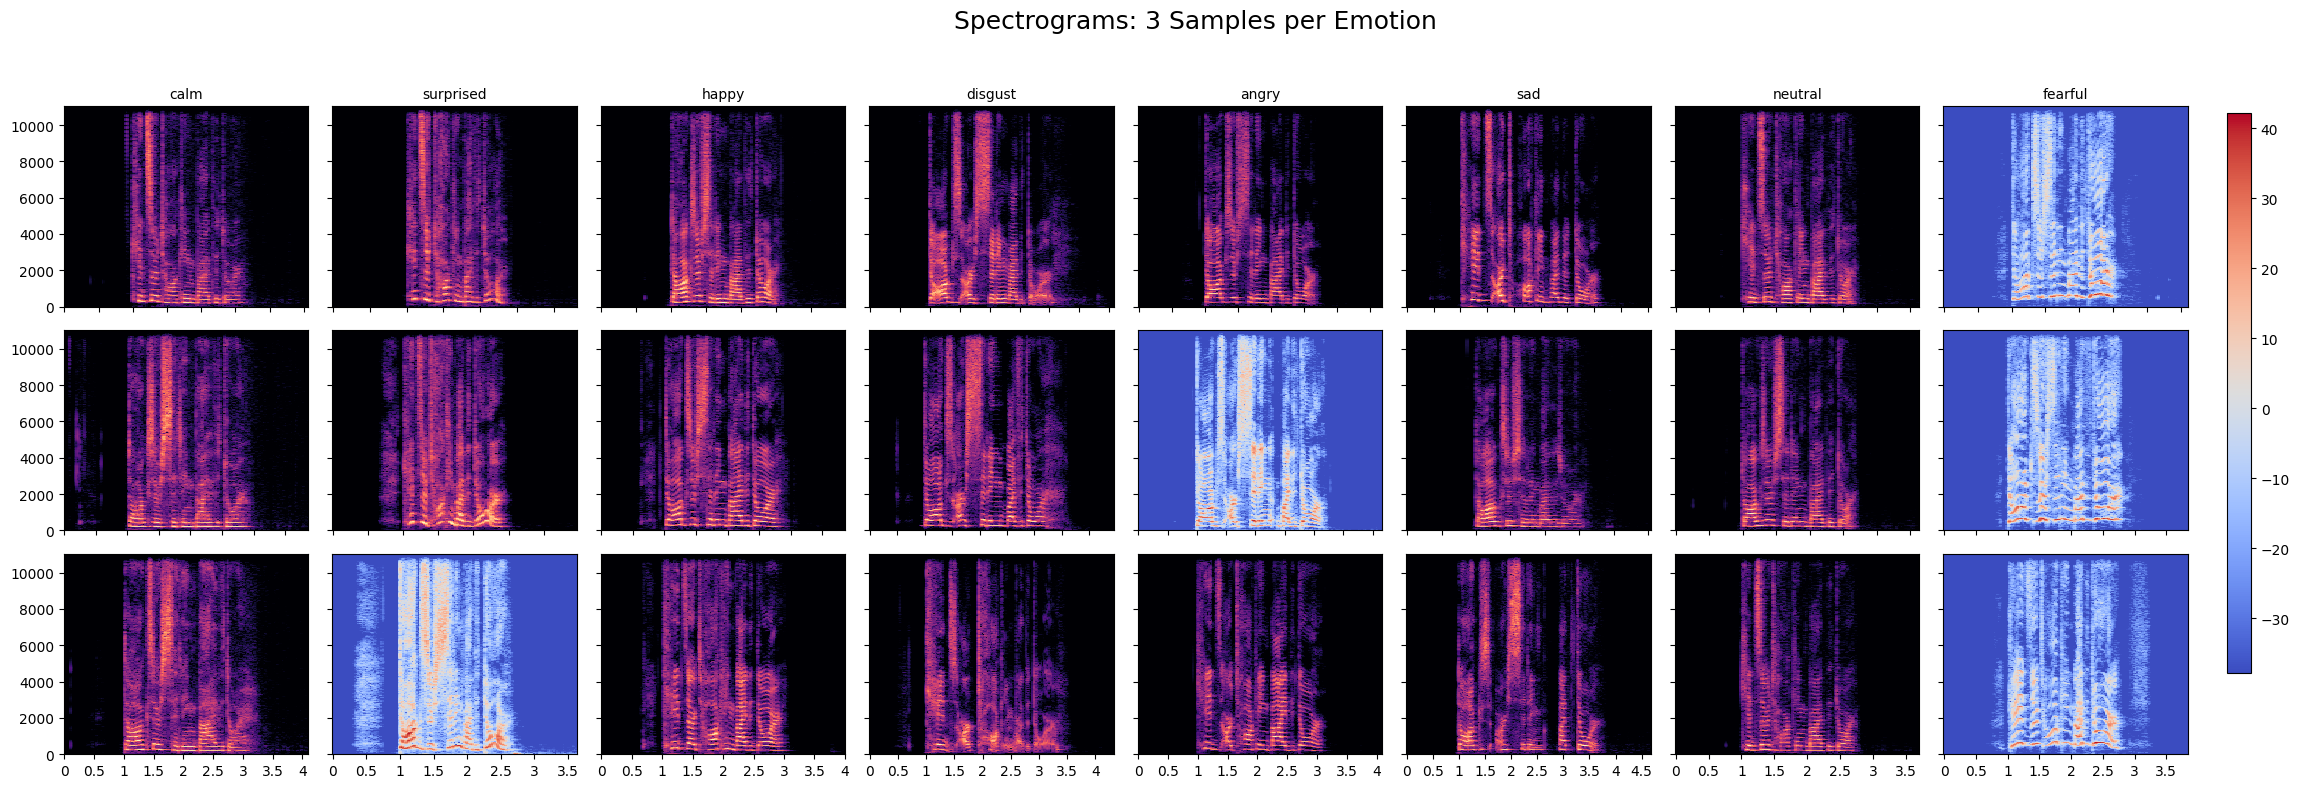

In [26]:
fig, axes = plt.subplots(3, 8, figsize=(24, 8))
fig.suptitle('Spectrograms: 3 Samples per Emotion', fontsize=18)

for col_idx, emotion in enumerate(emotion_labels):
    emotion_samples = df[df['emotion'] == emotion].head(3)

    for row_idx, (_, row) in enumerate(emotion_samples.iterrows()):
        path = row['filename']
        data, sr = librosa.load(path)

        x = librosa.stft(data)
        xdb = librosa.amplitude_to_db(abs(x))

        ax = axes[row_idx, col_idx]
        img = librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz', ax=ax)
        
        if row_idx == 0:
            ax.set_title(emotion, fontsize=10)
        
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.label_outer()

fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
fig.colorbar(img, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.92, 0.95])
plt.show()

We can see some strong similarities in the patterns in some labels which is a good sign.

## Audio Duration

In [28]:
def extract_duartion(filename):
    y, sr = librosa.load(filename)
    duration = librosa.get_duration(y=y, sr=sr)
    return duration

In [32]:
df['duration'] = df['filename'].apply(extract_duartion)

In [33]:
df.columns

Index(['filename', 'modality', 'vocal_channel', 'emotion',
       'emontion_intensity', 'statement', 'repetition', 'actor', 'gender',
       'duartion', 'duration'],
      dtype='object')

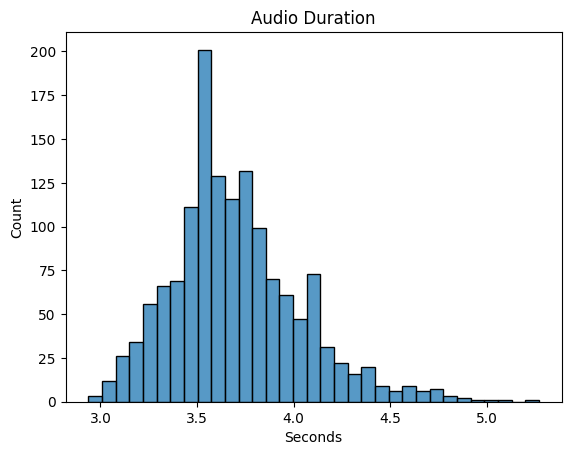

In [39]:
sns.histplot(df['duration'])
plt.title('Audio Duration')
plt.xlabel("Seconds");

It seems normally distributed with almost all the audio is less that 4.5 seconds

In [41]:
print(f"{round(df[df['duration'] <= 4.5].shape[0] / len(df),2) * 100}% of the audio is less than or rqual 4.5 seconds ")

97.0% of the audio is less than or rqual 4.5 seconds 
